# Face Recognition

## Build a neural network for faces classification as discribed above.

### Dataset 

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip -q '/content/drive/MyDrive/Colab Notebooks/Face Recognition/celebA_train_1k.zip'

In [ ]:
! ls celebA_train_1k

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io, transform
from time import time
import math
import random
from IPython.display import clear_output
from tqdm import tqdm, tqdm_notebook
import seaborn as sns

import torch
from torchvision import models as mdl
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import DataParallel

import matplotlib.pyplot as plt

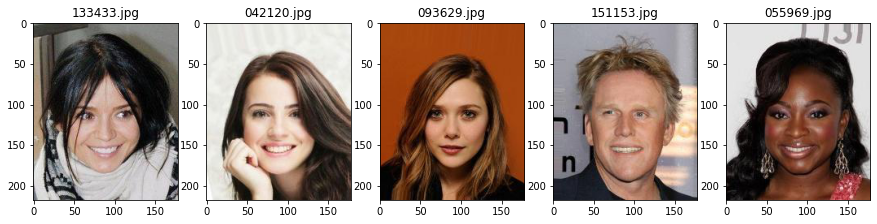

In [ ]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_1k/celebA_imgs/', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('./celebA_train_1k/celebA_imgs/')[:5]
show_imgs(images_names)


### Train Neural Network

In [ ]:
folder_to_save = '/content/drive/MyDrive/Colab Notebooks/Face Recognition/model.pt'
# training parameters
epochs = 10
step_size = 2
gamma = 0.5
lr = 1e-4
batch_size = 128
childrens_to_freeze = 14

In [ ]:
def get_paths(dataset_type='train'):
    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }
    f = open('celebA_train_1k/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('celebA_train_1k/celebA_imgs/', filename))
    
    return np.array(images_paths)


class celebADataset(Dataset):
    def __init__(self, dataset_type, transform=None):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_1k/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform = {
            'val': transforms.Compose([
                transforms.Resize(160),
                transforms.CenterCrop(160),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'train': transforms.Compose([
                transforms.Resize(160),
                transforms.CenterCrop(160),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])}

cel_train_data = celebADataset('train', transform['train'])
cel_val_data = celebADataset('val', transform['val'])
cel_test_data = celebADataset('test', transform['val'])

cel_train_loader = torch.utils.data.DataLoader(cel_train_data, batch_size=batch_size, shuffle=True)
cel_val_loader = torch.utils.data.DataLoader(cel_val_data, batch_size=batch_size, shuffle=False)
cel_test_loader = torch.utils.data.DataLoader(cel_test_data, batch_size=batch_size, shuffle=False)

In [ ]:
def cel_fit_epoch(model, train_loader, criterion, optimizer):
  accuracy = 0.0
  mean_loss = 0.0
  # training part
  model.train()
  for X, labels in train_loader:
    X = torch.FloatTensor(X).to(device)
    labels = torch.LongTensor(labels).to(device)

    outputs = model(X)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculating accuracy
    outputs = outputs.data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    outputs = np.argmax(outputs, 1)
    
    acc = np.mean((outputs == labels).astype(int))
    accuracy += acc/len(train_loader)
    mean_loss += loss/len(train_loader)

  return mean_loss, accuracy

In [ ]:
def cel_val_epoch(model, val_loader, criterion):
  model.eval()
  accuracy = 0.0
  mean_loss = 0.0
  for X, labels in val_loader:
    with torch.no_grad():
      X = torch.FloatTensor(X).to(device)
      labels = torch.LongTensor(labels).to(device)

      outputs = model(X)
      loss = criterion(outputs, labels)

      # calculating accuracy
      outputs = outputs.data.cpu().numpy()
      labels = labels.data.cpu().numpy()
      outputs = np.argmax(outputs, 1)
      
      acc = np.mean((outputs == labels).astype(int))
      accuracy += acc/len(val_loader)
      mean_loss += loss/len(val_loader)

  return mean_loss, accuracy

In [ ]:
def cel_train(train_loader, val_loader, model, criterion, optimizer, epochs, scheduler):
  data = []
  best_acc = 0.0
  tok = time()
  log_temp = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

  with tqdm(desc="epoch", total=epochs) as pbar_outer:
    for epoch in range(epochs):
      train_loss, train_acc = cel_fit_epoch(model, train_loader, criterion, optimizer)
      # validation part
      val_loss, val_acc = cel_val_epoch(model, val_loader, criterion)
      data.append((train_loss, train_acc, val_loss, val_acc))
      # progress bar 
      pbar_outer.update(1)
      tqdm.write(log_temp.format(ep=epoch+1, t_loss=train_loss,\
                                            v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
      if val_acc >= best_acc:
          best_acc = val_acc
          torch.save(model.state_dict(), folder_to_save)
      scheduler.step()  

  tik = time()
  print(f"\n\nTime spent: {(tik-tok):.0f} seconds")
  return data

In [ ]:
def cel_predict(test_loader, model):
  accuracy = 0.0
  model = model.to('cpu')
  model.eval()
  with torch.no_grad():
    for X, labels in test_loader:
      X = torch.FloatTensor(X).to('cpu')
      outputs = model(X)

      # calculating accuracy
      # outputs = F.softmax(outputs, dim=1)
      outputs = outputs.data.cpu().numpy()
      labels = labels.data.cpu().numpy()
      outputs = np.argmax(outputs, 1)
      
      acc = np.mean((outputs == labels).astype(int))
      accuracy += acc/len(test_loader)

  print(f'Test accuracy: {accuracy}')

In [ ]:
def cel_visual(values):
  losses_train, acc_train, losses_val, acc_val = zip(*values)
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax = ax.ravel()

  ax[0].plot(losses_train, label='losses_train')
  ax[0].plot(losses_val, label='losses_val')
  ax[0].legend(loc='best')
  ax[0].set_title('Loss')

  ax[1].plot(acc_train, label='acc_train')
  ax[1].plot(acc_val, label='acc_val')
  ax[1].legend(loc='best')
  ax[1].set_title('Accuracy')
  
  fig.show()

In [ ]:
! git clone https://github.com/timesler/facenet-pytorch.git
! mv facenet-pytorch/models ./

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1267, done.
remote: Total 1267 (delta 0), reused 0 (delta 0), pack-reused 1267
Receiving objects: 100% (1267/1267), 22.88 MiB | 14.20 MiB/s, done.
Resolving deltas: 100% (620/620), done.


In [ ]:
from models import inception_resnet_v1
cel_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = 1000)
cel_model.last_linear = nn.Linear(in_features=1792, out_features=1000, bias=False)
cel_model.last_bn = nn.BatchNorm1d(1000, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
count = 0
for child in cel_model.children():
  count += 1
  if count >= childrens_to_freeze:
    for param in child.parameters():
      param.requires_grad = False

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cel_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma, verbose=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
cel_model = cel_model.to(device)
cel_model.aux_logits = False
print(device)

cuda


In [ ]:
cel_history = cel_train(cel_train_loader, cel_val_loader, cel_model, criterion, optimizer, epochs, scheduler)

epoch:  10%|█         | 1/10 [01:56<17:32, 116.99s/it]


Epoch 001 train_loss: 6.8814     val_loss 6.8283 train_acc 0.0218 val_acc 0.2681


epoch:  20%|██        | 2/10 [04:02<16:14, 121.86s/it]


Epoch 002 train_loss: 6.8346     val_loss 6.7730 train_acc 0.2128 val_acc 0.6287


epoch:  30%|███       | 3/10 [06:07<14:24, 123.45s/it]


Epoch 003 train_loss: 6.7967     val_loss 6.7340 train_acc 0.5410 val_acc 0.7535


epoch:  40%|████      | 4/10 [08:12<12:23, 123.88s/it]


Epoch 004 train_loss: 6.7735     val_loss 6.7074 train_acc 0.7152 val_acc 0.8152


epoch:  50%|█████     | 5/10 [10:18<10:23, 124.67s/it]


Epoch 005 train_loss: 6.7536     val_loss 6.6868 train_acc 0.8349 val_acc 0.8376


epoch:  60%|██████    | 6/10 [12:23<08:19, 124.79s/it]


Epoch 006 train_loss: 6.7418     val_loss 6.6730 train_acc 0.8712 val_acc 0.8536


epoch:  70%|███████   | 7/10 [14:25<06:11, 123.97s/it]


Epoch 007 train_loss: 6.7315     val_loss 6.6625 train_acc 0.9007 val_acc 0.8613


epoch:  80%|████████  | 8/10 [16:28<04:07, 123.53s/it]


Epoch 008 train_loss: 6.7252     val_loss 6.6553 train_acc 0.9124 val_acc 0.8626


epoch:  90%|█████████ | 9/10 [18:30<02:03, 123.26s/it]


Epoch 009 train_loss: 6.7195     val_loss 6.6511 train_acc 0.9213 val_acc 0.8644


epoch: 100%|██████████| 10/10 [20:32<00:00, 122.94s/it]


Epoch 010 train_loss: 6.7162     val_loss 6.6479 train_acc 0.9216 val_acc 0.8696


epoch: 100%|██████████| 10/10 [20:33<00:00, 123.34s/it]



Time spent: 1233 seconds


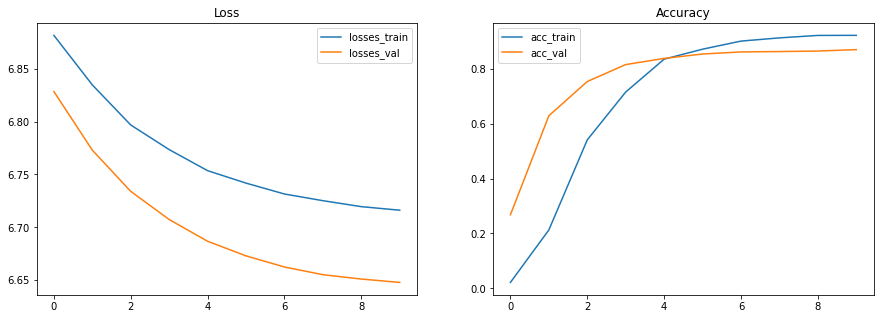

In [ ]:
cel_visual(cel_history)

In [ ]:
cel_predict(cel_test_loader, cel_model)

Test accuracy: 0.853406862745098


In [ ]:
cel_model.load_state_dict(torch.load(folder_to_save))

<All keys matched successfully>

In [ ]:
cel_predict(cel_test_loader, cel_model)

Test accuracy: 0.853406862745098


**Cosine similarity calculation**: drop a last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x
cel_model.logits = Identity()

In [ ]:
def get_images(number, train, test):
  train_pos = []
  test_neg = []
  test_pos = []
  train_neg = []

  #find similar
  for image, label in train:
    if label == number:
      train_pos.append(image)
  for image, label in test:
    if label == number:
      test_pos.append(image)

  count_negatives = 500 #train_pos.shape[0]
  count = 0

  #find opposite
  for image, label in train:
    if label != number and count<count_negatives:
      train_neg.append(image)
      count += 1

  return torch.stack(train_pos), torch.stack(test_pos), torch.stack(train_neg)

In [ ]:
def get_embeddings(model, train_images, test_images):
  model.eval()
  with torch.no_grad():
    emb1 = model(train_images)
    emb2 = model(test_images)
  return emb1, emb2

In [ ]:
def calculate_cos_sim(train_embed, test_embed):
  cos = []
  for ts_embed in test_embed:
    temp_cos = []
    for tr_embed in train_embed:
      temp_cos.append(torch.cosine_similarity(ts_embed.reshape(1, -1), tr_embed.reshape(1, -1)).item())
    cos.append(temp_cos)
  return cos

In [ ]:
number = 100
train_pos, test_pos, train_neg = get_images(number, cel_train_data, cel_test_data)
cos = calculate_cos_sim(*list(get_embeddings(cel_model, test_pos, train_pos)))
cos_dif = calculate_cos_sim(*list(get_embeddings(cel_model, test_pos, train_neg)))

One human

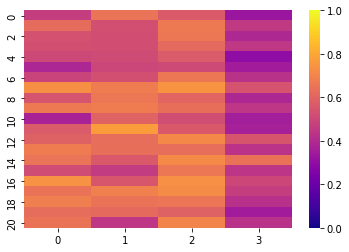

In [ ]:
fig = plt.figure()
sns.heatmap(cos, annot=False, cmap='plasma', vmin=0, vmax=1)
fig.show()

Different

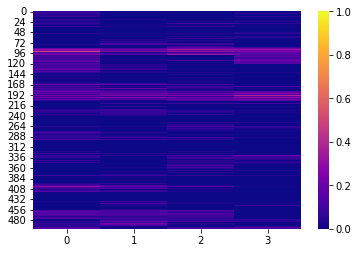

In [ ]:
sns.heatmap(cos_dif, annot=False, cmap='plasma', vmin=0, vmax=1)
fig.show()

## Identificaton rate metric

In [ ]:
! unzip -q '/content/drive/MyDrive/Colab Notebooks/Face Recognition/celebA_ir.zip'

In [ ]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format: 
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.txt', 'r')
query_lines = f.readlines()
f.close()
query_lines = [x.strip().split() for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')

In [ ]:
def get_paths_ir(images_list, distractors):
    image_paths = []
    count = 30000
    for i, filename in enumerate(images_list):    
      if i<count:
        if not distractors:
          image_paths.append(os.path.join('celebA_ir/celebA_query/', filename))
        else:
          image_paths.append(os.path.join('celebA_ir/celebA_distractors/', filename))
      else:
        return image_paths
    return image_paths

In [ ]:
class celebAirDataset(Dataset):
    def __init__(self, images_list, distractors, transform=None):
        self.images = get_paths_ir(images_list, distractors)
        self.distractors = distractors
        if not self.distractors:
          f = open('./celebA_ir/celebA_anno_query.txt', 'r')
          lines = f.readlines()
          f.close()

          labels = [x.strip().split() for x in lines]
          labels = {x:y for x, y in labels}
          self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]        
        image = Image.open(img_name)       
        if self.transform:
            image = self.transform(image)
        if self.distractors:
          return image
        else:
          label = self.labels[idx]
          return image, label

In [ ]:
def compute_embeddings(model, images_list, batch_size, distractors):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    tensor: tensor of model embeddings. Each embedding corresponds to images 
          names from images_list. Shape = +-len(images_list) x 1000 (because we drop last batch in dataloader)
  '''
  embed_data = celebAirDataset(images_list, distractors, transform['train'])
  embed_loader = torch.utils.data.DataLoader(embed_data, batch_size=batch_size, shuffle=False, drop_last=True)
  model.eval()
  with torch.no_grad():
    for i, batch in enumerate(embed_loader):
      if not i:  
        if not distractors:
          embeddings = model(batch[0])
        else:
          embeddings = model(batch)
      else:  
        if not distractors:
          embeddings = torch.cat((embeddings, model(batch[0])), 0)
        else:
          embeddings = torch.cat((embeddings, model(batch)), 0)
  return embeddings

In [ ]:
query_embeddings = compute_embeddings(cel_model, query_img_names, 64, False)

In [ ]:
print(query_embeddings.shape, len(query_img_names))

torch.Size([7168, 1000]) 7198


In [ ]:
distractors_embeddings = compute_embeddings(cel_model, distractors_img_names, 64, True)

In [ ]:
print(distractors_embeddings.shape, len(distractors_img_names))

torch.Size([23360, 1000]) 23397


Выровняем теперь все списки с учетом того, что часть данных потерялась из-за drop_last=True

In [ ]:
query_embeddings = query_embeddings[:query_embeddings.shape[0]]
distractors_embeddings = distractors_embeddings[:distractors_embeddings.shape[0]]

query_lines = query_lines[:query_embeddings.shape[0]]
# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

In [ ]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding 
                    to the same people from query list
  '''
  cos = []
  embed_dict = {query_img_names[i]:query_embeddings[i] for i in range(query_embeddings.shape[0])} # by img name
  for clas in query_dict: # for each class
    temp_cos = []
    clas_embeddings = []
    for name in query_dict[clas]:
      # get embeddings of images in this class
      clas_embeddings.append(embed_dict[name])

    for i, name in enumerate(query_dict[clas]): # for each image_name from our class
      # get embedding of this image
      embedding = embed_dict[name]
      # calculate cos_sim for each pair
      for e in range(i, len(clas_embeddings)):
        emb = clas_embeddings[e]
        if torch.sum(torch.eq(emb, embedding)) != len(query_dict): # num of classes
          temp_cos.append(torch.cosine_similarity(embedding.reshape(1, -1), emb.reshape(1, -1)).item())
    if temp_cos: cos.append(temp_cos)
  
  cos_query_pos = []
  for x in cos:
    for y in x:
      cos_query_pos.append(y)
  return cos_query_pos

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding 
                    to different people from query list
  '''
  count = 1000000
  counter = 0
  cos = []
  embed_dict = {query_img_names[i]:query_embeddings[i] for i in range(query_embeddings.shape[0])} # by img name
  for i, clas in enumerate(query_dict): # for each class
    temp_cos = []
    clas_embeddings = []
    for name in query_dict[clas]:
      # get embeddings of this class
      clas_embeddings.append(embed_dict[name])
    for name in query_dict[clas]: # for each image_name in this class
      # get embedding of this image
      embedding = embed_dict[name]
      # calculate cos_sim for each pair
      for j, cls in enumerate(query_dict):   # prevent images from previous classes
        if cls!=clas and j>i:
          cls_embeddings = []
          for name in query_dict[cls]:
          # get embeddings of different class
            cls_embeddings.append(embed_dict[name])
          # calculate cos_sim for each pair
          for emb in cls_embeddings:
            if torch.sum(torch.eq(emb, embedding)) != len(query_dict): # num of classes
              temp_cos.append(torch.cosine_similarity(embedding.reshape(1, -1), emb.reshape(1, -1)).item())

            counter += 1
            if counter >= count:
              cos.append(temp_cos)
              cos_query_neg = []
              for x in cos:
                for y in x:
                  cos_query_neg.append(y)
              return cos_query_neg
    if temp_cos: cos.append(temp_cos)

  # transform to list
  cos_query_neg = []
  for x in cos:
    for y in x:
      cos_query_neg.append(y)
  return cos_query_neg

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is 
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  cos = []
  count = 1000000
  counter = 0
  for q in query_embeddings:
    for d in distractors_embeddings:
      cos.append(torch.cosine_similarity(q.reshape(1, -1), d.reshape(1, -1)).item())
      counter += 1
      if counter>=count:
        return cos
  return cos

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, 
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, 
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, 
                                                            distractors_embeddings)


In [ ]:
print(len(cosine_query_pos))
print(len(cosine_query_neg))
print(len(cosine_query_distractors))

95785
1000000
1000000


Check you code of functions which compute similarities:

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = torch.tensor([
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
])

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = torch.tensor([
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
])

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings, 
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

Implement the final function: identification rate calculation

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 
               fpr=0.1):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs 
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output: 
    float: threshold for given fpr 
    float: TPR at given FPR
  '''
  all = cosine_query_neg+cosine_query_distractors
  all = sorted(all, reverse=True)
  threshold = all[int(len(all)*fpr)]
  number = 0
  for i in cosine_query_pos:
    if i > threshold:
      number += 1
  tpr = number/len(cosine_query_pos)
  return threshold, tpr

Check yourself:

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, 
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

In [ ]:
fprs = [0.5, 0.2, 0.1, 0.05]
tprs = []
for fpr in fprs:
  thr, tpr = compute_ir(cosine_query_pos, cosine_query_neg, 
                    cosine_query_distractors, fpr=fpr)
  tprs.append(tpr)
  
tprs

[0.9612152215900193,
 0.8918933027091924,
 0.8219763010909851,
 0.7441666231664665]

## Loss functions

In [ ]:
class TripletcelebADataset(Dataset):
    def __init__(self, dataset_type, transform=None):
        self.paths = get_paths(dataset_type=dataset_type)
        self.dataset_type = dataset_type
        f = open('celebA_train_1k/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.paths]
        self.labels = np.array(self.labels)
        self.transform = transform
        self.indices = np.arange(0, len(self.paths), 1, dtype=int)

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):        
        anchor_path = self.paths[idx]
        label = self.labels[idx]
        index = self.indices[idx]
        anchor_img = Image.open(anchor_path)

        try:    # we can have only one element
          positive_list = self.indices[self.indices!=index][self.labels[self.indices!=index]==label]
          positive_item = random.choice(positive_list)
        except IndexError:
          positive_list = self.indices[self.labels==label]
          positive_item = random.choice(positive_list)

        positive_img = Image.open(self.paths[positive_item])

        negative_list = self.indices[self.indices!=index][self.labels[self.indices!=index]!=label]
        negative_item = random.choice(negative_list)
        negative_img = Image.open(self.paths[negative_item])

        if self.transform:
          anchor_img = self.transform(anchor_img)
          positive_img = self.transform(positive_img)
          negative_img = self.transform(negative_img)

        return anchor_img, label, positive_img, negative_img

In [ ]:
train_triplet_data = TripletcelebADataset('train', transform['train'])
val_triplet_data = TripletcelebADataset('val', transform['val'])
test_triplet_data = TripletcelebADataset('test', transform['val'])

In [ ]:
batch_size = 32
train_loader_triplet = torch.utils.data.DataLoader(train_triplet_data, batch_size=batch_size, shuffle=True)
val_loader_triplet = torch.utils.data.DataLoader(val_triplet_data, batch_size=batch_size, shuffle=False)
test_loader_triplet = torch.utils.data.DataLoader(test_triplet_data, batch_size=batch_size, shuffle=False)

In [ ]:
class TripletLoss(nn.Module):
  def __init__(self, margin=1.0):
    super(TripletLoss, self).__init__()
    self.margin = margin

  def distance_func(self, x1, x2):
    return (x1 - x2).pow(2).sum(1)
  
  def forward(self, anchor, positive, negative):
    positive_distance = self.distance_func(anchor, positive)
    negative_distance = self.distance_func(anchor, negative)
    loss = torch.relu(positive_distance - negative_distance + self.margin)
    return loss.mean()

In [ ]:
def metric(anchor_embeddings, positive_embeddings):
  anchor_embeddings = anchor_embeddings.cpu().detach().reshape(len(anchor_embeddings), -1)
  positive_embeddings = positive_embeddings.cpu().detach().reshape(len(positive_embeddings), -1)

  similarity = torch.nn.functional.cosine_similarity(anchor_embeddings, positive_embeddings)

  return similarity.mean().item()

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, metric):
  mean_loss = 0
  mean_acc = 0
  # training part
  model.train()
  for anchor_imgs, labels, positive_imgs, negative_imgs in train_loader:
    anchor_imgs = anchor_imgs.to(device)
    positive_imgs = positive_imgs.to(device)
    negative_imgs = negative_imgs.to(device)

    optimizer.zero_grad()

    anchor_embeddings = model(anchor_imgs)
    positive_embeddings = model(positive_imgs)
    negative_embeddings = model(negative_imgs)

    # hystogram(anchor_embeddings, positive_embeddings, negative_embeddings)

    loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
    accuracy = metric(anchor_embeddings, positive_embeddings)

    loss.backward()
    optimizer.step()

    mean_loss += loss.cpu().detach().numpy() / len(train_loader)
    mean_acc += accuracy / len(train_loader)

  return mean_loss, mean_acc

In [ ]:
def val_epoch(model, val_loader, criterion, metric):
  mean_loss = 0
  mean_acc = 0
  # validation part
  model.eval()
  with torch.no_grad():
    for anchor_imgs, labels, positive_imgs, negative_imgs in val_loader:
      anchor_imgs = anchor_imgs.to(device)
      positive_imgs = positive_imgs.to(device)
      negative_imgs = negative_imgs.to(device)

      anchor_embeddings = model(anchor_imgs)
      positive_embeddings = model(positive_imgs)
      negative_embeddings = model(negative_imgs)

      # hystogram(anchor_embeddings, positive_embeddings, negative_embeddings)

      loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
      accuracy = metric(anchor_embeddings, positive_embeddings)

      mean_loss += loss.cpu().detach().numpy() / len(val_loader)
      mean_acc += accuracy / len(val_loader)

  return mean_loss, mean_acc

In [ ]:
def train(train_loader, val_loader, model, criterion, metric, optimizer, epochs, scheduler):
  data = []
  with tqdm(desc="epoch", total=epochs) as pbar_outer:
    for epoch in range(epochs):
      train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, metric)
      # validation part
      val_loss, val_acc = val_epoch(model, val_loader, criterion, metric)
      data.append((train_loss, train_acc, val_loss, val_acc))
      # progress bar 
      pbar_outer.update(1)
      tqdm.write(f"\nEpoch {epoch+1} train_loss: {train_loss:.03} train_acc: {train_acc:.03} val_loss: {val_loss:.03} val_acc: {val_acc:.03}")
      scheduler.step()
  return data

In [ ]:
def visual(values):
  train_loss, train_acc, val_loss, val_acc = zip(*values)
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))

  ax[0].plot(train_loss, label='train_loss')
  ax[0].plot(val_loss, label='val_loss')
  ax[0].legend(loc='best')
  ax[0].set_title('Loss')

  ax[1].plot(train_acc, label='train_acc')
  ax[1].plot(val_acc, label='val_acc')
  ax[1].legend(loc='best')
  ax[1].set_title('Accuracy')

  fig.show()

In [ ]:
model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = 1000)
model.last_linear = nn.Linear(in_features=1792, out_features=1000, bias=False)
model.last_bn = nn.BatchNorm1d(1000, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
count = 0
for child in model.children():
  count += 1
  if count >= childrens_to_freeze:
    for param in child.parameters():
      param.requires_grad = False

model = model.to(device)
model.aux_logits = False

criterion = torch.jit.script(TripletLoss(margin=1))
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma, verbose=False)

In [ ]:
def hystogram(anchor_embeddings, positive_embeddings, negative_embeddings):
  anchor_embeddings = anchor_embeddings.cpu().detach().reshape(len(anchor_embeddings), -1)
  positive_embeddings = positive_embeddings.cpu().detach().reshape(len(positive_embeddings), -1)
  negative_embeddings = negative_embeddings.cpu().detach().reshape(len(negative_embeddings), -1)

  clear_output(wait=True)
  fig, ax = plt.subplots(1, 3, figsize=(10, 1))
  ax[1].set_title('positive')
  ax[2].set_title('negative')

  positives = torch.nn.functional.cosine_similarity(anchor_embeddings, positive_embeddings)
  negatives = torch.nn.functional.cosine_similarity(anchor_embeddings, positive_embeddings)

  sns.heatmap(positives, annot=False, cmap='plasma', ax=ax[1], vmin=0, vmax=1, xticklabels=False, yticklabels=False)
  sns.heatmap(negatives, annot=False, cmap='plasma', ax=ax[2], vmin=0, vmax=1, xticklabels=False, yticklabels=False)

  plt.show()

In [ ]:
history_triplet = train(train_loader_triplet, val_loader_triplet, model, criterion, metric, optimizer, epochs, scheduler)

epoch:  10%|█         | 1/10 [08:20<1:15:04, 500.52s/it]


Epoch 1 train_loss: 0.293 train_acc: 0.434 val_loss: 0.178 val_acc: 0.791


epoch:  20%|██        | 2/10 [16:38<1:06:30, 498.87s/it]


Epoch 2 train_loss: 0.216 train_acc: 0.514 val_loss: 0.15 val_acc: 0.782


epoch:  30%|███       | 3/10 [24:54<58:04, 497.82s/it]


Epoch 3 train_loss: 0.175 train_acc: 0.555 val_loss: 0.128 val_acc: 0.804


epoch:  40%|████      | 4/10 [33:10<49:42, 497.14s/it]


Epoch 4 train_loss: 0.157 train_acc: 0.572 val_loss: 0.117 val_acc: 0.81


epoch:  50%|█████     | 5/10 [41:26<41:22, 496.56s/it]


Epoch 5 train_loss: 0.135 train_acc: 0.591 val_loss: 0.109 val_acc: 0.823


epoch:  60%|██████    | 6/10 [49:41<33:04, 496.19s/it]


Epoch 6 train_loss: 0.126 train_acc: 0.601 val_loss: 0.105 val_acc: 0.824


epoch:  70%|███████   | 7/10 [57:58<24:48, 496.20s/it]


Epoch 7 train_loss: 0.115 train_acc: 0.61 val_loss: 0.0998 val_acc: 0.828


epoch:  80%|████████  | 8/10 [1:06:14<16:32, 496.35s/it]


Epoch 8 train_loss: 0.113 train_acc: 0.615 val_loss: 0.105 val_acc: 0.823


epoch:  90%|█████████ | 9/10 [1:14:30<08:16, 496.28s/it]


Epoch 9 train_loss: 0.105 train_acc: 0.62 val_loss: 0.0931 val_acc: 0.829


epoch: 100%|██████████| 10/10 [1:22:47<00:00, 496.73s/it]


Epoch 10 train_loss: 0.103 train_acc: 0.621 val_loss: 0.1 val_acc: 0.829


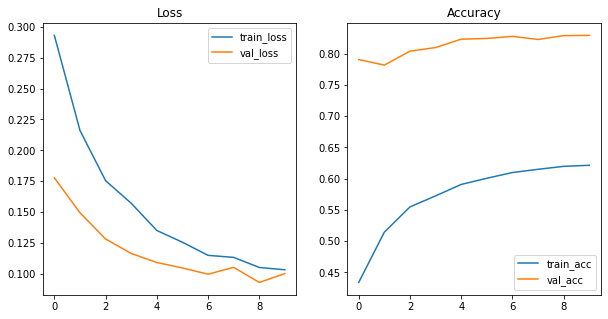

In [ ]:
visual(history_triplet)

In [ ]:
test_loss, test_acc = val_epoch(model, test_loader_triplet, criterion, metric)

In [ ]:
print(f'test loss: {test_loss:.02}\ntest acc: {test_acc:.02}')

test loss: 0.11
test acc: 0.82


In [ ]:
trpl_model = model

### ArcFace Loss (Additive Angular Margin Loss)

In [ ]:
folder_to_save = '/content/drive/MyDrive/Colab Notebooks/Face Recognition/model.pt'
# training parameters
epochs = 25
step_size = 5
gamma = 0.5
lr = 1e-4
batch_size = 16
childrens_to_freeze = 14
weight_decay = 5e-4

In [ ]:
arc_train_loader = torch.utils.data.DataLoader(cel_train_data, batch_size=batch_size, shuffle=True)
arc_val_loader = torch.utils.data.DataLoader(cel_val_data, batch_size=batch_size, shuffle=False)
arc_test_loader = torch.utils.data.DataLoader(cel_test_data, batch_size=batch_size, shuffle=False)

In [ ]:
class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0+1e-7, 1-1e-7))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [ ]:
def arc_fit_epoch(model, train_loader, criterion, metric_fc, optimizer):
  accuracy = 0.0
  mean_loss = 0.0
  # training part
  model.train()
  for X, labels in train_loader:
    X = torch.FloatTensor(X).to(device)
    labels = torch.LongTensor(labels).to(device)

    features = model(X) #model
    outputs = metric_fc(features, labels)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # calculating accuracy
    outputs = outputs.data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    outputs = np.argmax(outputs, 1)
    
    acc = np.mean((outputs == labels).astype(int))
    accuracy += acc/len(train_loader)
    mean_loss += loss/len(train_loader)

  return mean_loss, accuracy

In [ ]:
def arc_val_epoch(model, val_loader, criterion, metric_fc):
  model.eval()
  accuracy = 0.0
  mean_loss = 0.0
  for X, labels in val_loader:
    with torch.no_grad():
      X = torch.FloatTensor(X).to(device)
      labels = torch.LongTensor(labels).to(device)

      features = model(X) #model
      outputs = metric_fc(features, labels)
      loss = criterion(outputs, labels)
      
      # calculating accuracy
      outputs = outputs.data.cpu().numpy()
      labels = labels.data.cpu().numpy()
      outputs = np.argmax(outputs, 1)
      
      acc = np.mean((outputs == labels).astype(int))
      accuracy += acc/len(val_loader)
      mean_loss += loss/len(val_loader)

  return mean_loss, accuracy

In [ ]:
def arc_train(train_loader, val_loader, model, criterion, metric_fc, optimizer, epochs, scheduler):
  data = []
  best_acc = 0.0
  tok = time()
  log_temp = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
  with tqdm(desc="epoch", total=epochs) as pbar_outer:
    for epoch in range(epochs):
      train_loss, train_acc = arc_fit_epoch(model, train_loader, criterion, metric_fc, optimizer)
      # validation part
      val_loss, val_acc = arc_val_epoch(model, val_loader, criterion, metric_fc)
      data.append((train_loss, train_acc, val_loss, val_acc))
      # progress bar 
      pbar_outer.update(1)
      tqdm.write(log_temp.format(ep=epoch+1, t_loss=train_loss,\
                                            v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
      scheduler.step()  
  tik = time()
  print(f"\n\nTime spent: {(tik-tok):.0f} seconds")
  return data

In [ ]:
arc_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = 1000)
arc_model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False) # 512 is embedding size
arc_model.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
arc_model.logits = Identity() # to get embeddings

count = 0
for child in arc_model.children():
  count += 1
  if count >= childrens_to_freeze:
    for param in child.parameters():
      param.requires_grad = False

arc_model = arc_model.to(device)
arc_model.aux_logits = False


arc_model.to(device)
arc_model = DataParallel(arc_model)

metric_fc = ArcFaceLoss(512, 1000, 10, 0.1, False).to(device)
metric_fc = DataParallel(metric_fc)

optimizer = torch.optim.Adam([{'params': arc_model.parameters()},
                              {'params': metric_fc.parameters()}],
                              lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma, verbose=False)

In [ ]:
arc_history = arc_train(cel_train_loader, cel_val_loader, arc_model, criterion, metric_fc, optimizer, epochs, scheduler)

epoch:   4%|▍         | 1/25 [02:00<48:17, 120.71s/it]


Epoch 001 train_loss: 7.5281     val_loss 6.6481 train_acc 0.0002 val_acc 0.0172


epoch:   8%|▊         | 2/25 [04:03<46:42, 121.84s/it]


Epoch 002 train_loss: 6.6138     val_loss 5.6368 train_acc 0.0208 val_acc 0.1653


epoch:  12%|█▏        | 3/25 [06:05<44:42, 121.94s/it]


Epoch 003 train_loss: 5.7524     val_loss 4.7943 train_acc 0.1528 val_acc 0.3576


epoch:  16%|█▌        | 4/25 [08:13<43:34, 124.52s/it]


Epoch 004 train_loss: 4.9313     val_loss 4.0330 train_acc 0.3901 val_acc 0.5247


epoch:  20%|██        | 5/25 [10:17<41:23, 124.20s/it]


Epoch 005 train_loss: 4.1739     val_loss 3.3291 train_acc 0.6023 val_acc 0.6569


epoch:  24%|██▍       | 6/25 [12:21<39:17, 124.05s/it]


Epoch 006 train_loss: 3.4609     val_loss 2.8082 train_acc 0.7923 val_acc 0.7451


epoch:  28%|██▊       | 7/25 [16:04<46:58, 156.58s/it]


Epoch 007 train_loss: 3.0570     val_loss 2.5452 train_acc 0.8642 val_acc 0.7724


epoch:  32%|███▏      | 8/25 [20:15<52:52, 186.64s/it]


Epoch 008 train_loss: 2.7345     val_loss 2.3165 train_acc 0.9071 val_acc 0.7984


epoch:  36%|███▌      | 9/25 [24:10<53:44, 201.52s/it]


Epoch 009 train_loss: 2.4344     val_loss 2.0668 train_acc 0.9363 val_acc 0.8282


epoch:  40%|████      | 10/25 [27:49<51:44, 206.94s/it]


Epoch 010 train_loss: 2.1736     val_loss 1.9011 train_acc 0.9566 val_acc 0.8408


epoch:  44%|████▍     | 11/25 [32:06<51:52, 222.32s/it]


Epoch 011 train_loss: 1.9346     val_loss 1.7534 train_acc 0.9720 val_acc 0.8528


epoch:  48%|████▊     | 12/25 [35:26<46:44, 215.73s/it]


Epoch 012 train_loss: 1.8091     val_loss 1.6793 train_acc 0.9774 val_acc 0.8569


epoch:  52%|█████▏    | 13/25 [39:23<44:24, 222.01s/it]


Epoch 013 train_loss: 1.7014     val_loss 1.6177 train_acc 0.9815 val_acc 0.8609


epoch:  56%|█████▌    | 14/25 [42:50<39:53, 217.58s/it]


Epoch 014 train_loss: 1.6092     val_loss 1.5630 train_acc 0.9844 val_acc 0.8653


epoch:  60%|██████    | 15/25 [46:26<36:11, 217.16s/it]


Epoch 015 train_loss: 1.5297     val_loss 1.5189 train_acc 0.9863 val_acc 0.8661


epoch:  64%|██████▍   | 16/25 [50:20<33:17, 221.99s/it]


Epoch 016 train_loss: 1.4418     val_loss 1.4681 train_acc 0.9891 val_acc 0.8718


epoch:  64%|██████▍   | 16/25 [52:06<29:18, 195.39s/it]


KeyboardInterrupt: ignored

In [ ]:
cel_visual(arc_history)